In [3]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from itertools import product

               Close
Date                
2021-01-01  0.005685
2021-01-02  0.010615
2021-01-03  0.009771
2021-01-04  0.009767
2021-01-05  0.009920
...              ...
2022-07-16  0.064280
2022-07-17  0.063107
2022-07-18  0.067715
2022-07-19  0.069013
2022-07-20  0.070945

[566 rows x 1 columns]


<Axes: xlabel='Date'>

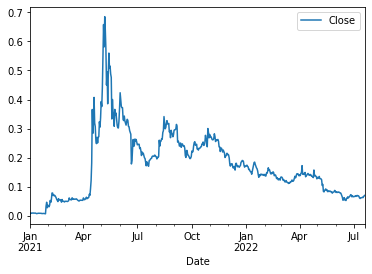

In [4]:
# load the data
df = pd.read_csv('DOGE-USD-daily 2021.csv', header = 0)
df.dropna()
df.head()
close_price = df[["Date", "Close"]].copy()
close_price.index = pd.to_datetime(close_price['Date'])
close_price.drop(columns='Date',inplace=True)
print(close_price)
close_price.plot()

<Axes: xlabel='Date', ylabel='Resid'>

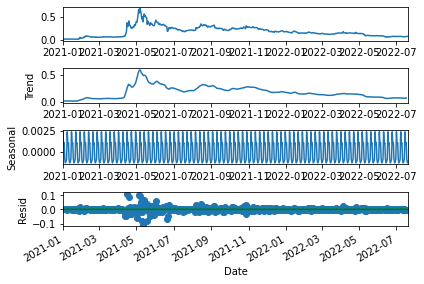

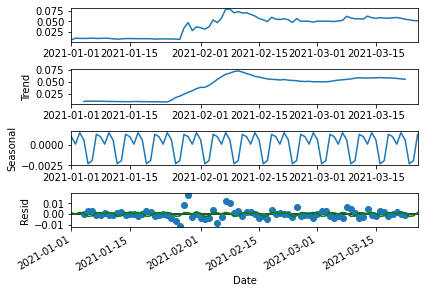

In [5]:
# decompose data
decompose_data = seasonal_decompose(close_price, model="additive")
decompose_data.plot()
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

first_n_row = close_price.iloc[0:84, :1]

decompose_data2 = seasonal_decompose(first_n_row, model="additive")
decompose_data2.plot()
seasonality2=decompose_data2.seasonal
seasonality2.plot(color='green')

The series is stationary


/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


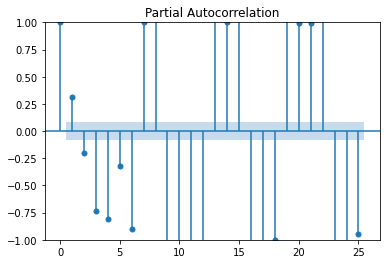

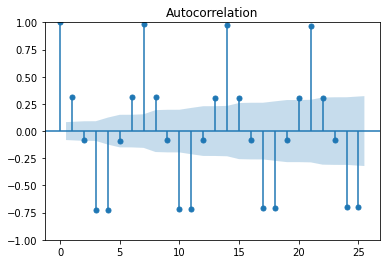

In [6]:
# check stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(seasonality)
# plot acf, pacf
plot_pacf(seasonality, lags =25)
plt.show()
plot_acf(seasonality, lags =25)
plt.show()

In [7]:
# make the data stationary
ln_close = np.log(close_price)
x0 = ln_close.loc["2022-06-20"]

dftest = adfuller(ln_close.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.9401136920222317
2. P-Value :  0.04087823222146439
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 562
5. Critical Values :
	 1% :  -3.442039359113542
	 5% :  -2.8666965134862514
	 10% :  -2.5695162601790758


In [8]:
# split data
m = 30
print(len(ln_close))
train_data = ln_close[0:len(ln_close)-m]
test_data = ln_close[len(ln_close)-m:len(ln_close)]

566


In [9]:
# Load and prepare external variables
UDI = pd.read_excel('US Dollar Index.xlsx', index_col=0, header=0)
udi = UDI["UDI"].shift(1)  # Create lagged feature

BTC = pd.read_excel("BTC-USD.xlsx", index_col=0, header=0)
BTC_Close = BTC["BTC_Close"].shift(1)  # Create lagged feature

MSCI_AIWC = pd.read_excel('MSCI_AIWC.xlsx', index_col=0, header=0)
MSCI_AIWC = MSCI_AIWC["close"].shift(1)  # Create lagged feature

COVID_19 = pd.read_excel('WHO_ USA_ COVID-19.xlsx', index_col=0, header=0)
YTD = COVID_19["YTD"].shift(1)  # Create lagged feature
NCC = COVID_19["New_Confirmed_Cases"].shift(1)  # Create lagged feature

Oil = pd.read_excel('Futures Settlement Price (Continuous)_ Brent Crude Oil.xlsx', index_col=0, header=0)
Brent = Oil["Brent"].shift(1)  # Create lagged feature

# Handle NaN values that result from shifting
udi.fillna(method='bfill', inplace=True)
BTC_Close.fillna(method='bfill', inplace=True)
MSCI_AIWC.fillna(method='bfill', inplace=True)
YTD.fillna(method='bfill', inplace=True)
NCC.fillna(method='bfill', inplace=True)
Brent.fillna(method='bfill', inplace=True)

# Merge lagged external variable data
merge_df = train_data.join(udi)
merge_df = merge_df.join(BTC_Close)
merge_df = merge_df.join(MSCI_AIWC.rename("MSCI_ACWI"))
merge_df = merge_df.join(YTD)
merge_df = merge_df.join(NCC)
merge_df = merge_df.join(Brent[:-2])
exog_lst = merge_df.iloc[:, 1:]

# Apply a comprehensive cleaning method based on the diagnosis
def clean_data(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities if any
    df.fillna(method='bfill', inplace=True)  # Backfill as a more aggressive approach
    return df

# Assuming 'merge_df' is your dataframe after merging all external variables and before shifting
cleaned_exog_lst = clean_data(merge_df)

# Now, shift all columns to create lagged features
cleaned_exog_lst = cleaned_exog_lst.shift(1)
cleaned_exog_lst.fillna(method='bfill', inplace=True)  # Ensure no NaNs after shifting

# Re-check for cleanliness
if not cleaned_exog_lst.isnull().values.any() and not np.isinf(cleaned_exog_lst.values).any():
    print("Exog data is clean and ready for model fitting.")
else:
    print("Exog data still contains NaNs or infinite values. Further cleaning required.")

Exog data is clean and ready for model fitting.


In [10]:
# find relevant exog variables
model = sm.tsa.statespace.SARIMAX(
    train_data,
    exog=cleaned_exog_lst,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False, enforce_invertibility=False,
    freq="D").fit(method="powell", disp=False)

model.summary()

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  536
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                 403.320
Date:                           Sat, 30 Mar 2024   AIC                           -782.641
Time:                                   13:23:15   BIC                           -731.595
Sample:                               01-01-2021   HQIC                          -762.644
                                    - 06-20-2022                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Close                   0.9726      0.009    114.252      0.000       0.956       0.989
UDI                    -0.0034      0.006     -0.552      0.581      -0.016       0.009
BTC_Close            3.214e-07   6.85e-07      0.469      0.639   -1.02e-06    1.66e-06
MSCI_ACWI               0.0002      0.000      0.671      0.502      -0.000       0.001
YTD                  3.304e-10   1.82e-09      0.182      0.856   -3.23e-09    3.89e-09
New_Confirmed_Cases -3.165e-08   7.97e-08     -0.397      0.691   -1.88e-07    1.24e-07
Brent                6.708e-05      0.002      0.038      0.970      -0.003       0.004
ar.L1                  -0.8694      0.007   -117.919      0.000      -0.884      -0.855
ma.L1                   0.9295      0.007    129.018      0.000       0.915       0.944
ar.S.L7                -0.0002   6.69e-05     -2.656      0.008      -0.000   -4.66e-05
ma.S.L7                -0.9702      0.001  -1904.418      0.000      -0.971      -0.969
sigma2                  0.0120      0.000     47.390      0.000       0.012       0.013
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):             39166.40
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             3.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.15e+18. Standard errors may be unstable.
"""

None of the exog variables are significant. We should remove them and re-fit the model.

In [11]:
p = q = range(0,4)
Ps = Qs = range(0,4)
parameters = product(p, q, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [21]:
# calculate MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Tune the model
# grid search to select parameter
def gs_arima(ts, parameters_list, d, Ds, s, opt_method='powell', freq='D'):
    results = []
    best_aic = float("inf")
    better_model = None
    better_param = None

    for param in parameters_list:
        try:
            model = sm.tsa.statespace.SARIMAX(
                ts,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], Ds, param[3], s),
                enforce_stationarity=False,
                enforce_invertibility=False,
                freq=freq).fit(method=opt_method, disp=False)
        except:
            continue

        aic = model.aic
        if aic < best_aic:
            better_model = model
            best_aic = aic
            better_param = param

        results.append([param, aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table, better_param, better_model


# merge exgo variable for test_data
# Prepare a dictionary of external variables to be merged with test_data
external_vars = {
    'UDI': udi,
    'BTC_Close': BTC_Close,
    'MSCI_AIWC': MSCI_AIWC,
    'YTD': YTD,
    'New_Confirmed_Cases': NCC,
    'Brent': Brent
}
# Initialize merge_df2 with test_data
merge_df2 = test_data.copy()
# Merge each external variable into merge_df2 and forward-fill any missing values
for var_name, series in external_vars.items():
    merge_df2 = merge_df2.join(series.rename(var_name))
    merge_df2[var_name].fillna(method='ffill', inplace=True)

# Assuming all other columns are external variables, extract them as exog_test
exog_test = merge_df2.iloc[:, 1:]

In [22]:
# tune the model to find the best one
# D = 1
result_table, best_param, best_model = gs_arima(
    ts=train_data,
    parameters_list=parameters_list,
    d=1,  # non-seasonal differencing
    Ds=1,  # seasonal differencing
    s=7,  # seasonal period
    opt_method='powell', # optimization method
    freq='D'  # frequency of the data (daily)
)

print(result_table)
print(best_param)
print(best_model.summary())

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency i

       parameters          aic
0    (3, 0, 2, 3) -1000.370917
1    (3, 1, 2, 3)  -996.389355
2    (0, 0, 2, 3)  -993.400323
3    (0, 1, 2, 3)  -993.059327
4    (0, 3, 2, 3)  -992.375250
..            ...          ...
251  (0, 2, 0, 0)  -468.176245
252  (2, 0, 0, 0)  -467.867369
253  (1, 1, 0, 0)  -467.352625
254  (0, 1, 0, 0)  -466.492228
255  (1, 3, 0, 0)  -461.009315

[256 rows x 2 columns]
(3, 0, 2, 3)


In [24]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Close   No. Observations:                  536
Model:             SARIMAX(3, 1, 0)x(2, 1, [1, 2, 3], 7)   Log Likelihood                 509.185
Date:                                   Sat, 30 Mar 2024   AIC                          -1000.371
Time:                                           14:03:28   BIC                           -962.332
Sample:                                       01-01-2021   HQIC                          -985.452
                                            - 06-20-2022                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0296      0.028     -1.042      0.297      -0.085       0.026
ar.L2          0.0544      0.032      1.719      0.086      -0.008       0.116
ar.L3          0.1448      0.030      4.855      0.000       0.086       0.203
ar.S.L7       -1.0361      0.033    -31.081      0.000      -1.101      -0.971
ar.S.L14      -0.5933      0.037    -15.911      0.000      -0.666      -0.520
ma.S.L7        0.1502      0.050      3.009      0.003       0.052       0.248
ma.S.L14      -0.3903      0.064     -6.093      0.000      -0.516      -0.265
ma.S.L21      -0.6115      0.052    -11.798      0.000      -0.713      -0.510
sigma2         0.0076      0.000     26.846      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1439.11
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

best model has:
    order=(3, 1, 0),  # Non-seasonal order
    seasonal_order=(2, 1, 3, 7),  # Seasonal order

0.021927488050519688
12.693492051808628
87.30650794819137
8.590652286213458e-05


<Axes: xlabel='Date'>

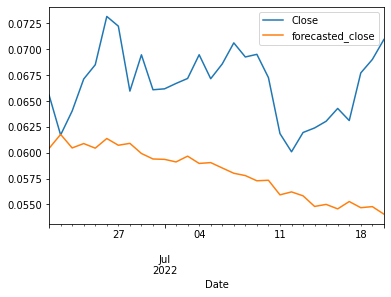

In [36]:
# predict
forecast_ln = best_model.predict(start=536, end=565, dynamic=True)
mse_pre = mean_squared_error(test_data, forecast_ln)
# reverse the prediction
forecasted_close = np.exp(forecast_ln)
# plot the result
test_data2 = close_price[len(ln_close)-m:len(ln_close)]
test_data_df = pd.DataFrame(test_data2)
forecasted_close = pd.DataFrame(forecasted_close)
test_data_df.insert(1, column="forecasted_close", value=forecasted_close)
mape_sarimax = mape(test_data_df.Close, forecasted_close)
mse = mean_squared_error(test_data_df.Close, forecasted_close)
print(mse_pre)
print(mape_sarimax)
print(100-mape_sarimax)
print(mse)
test_data_df[["Close", "forecasted_close"]].plot()

In [37]:
from sklearn.metrics import r2_score
# Assuming test_data_df['Close'] has the actual values and forecasted_close is your prediction
# Calculate the R-squared value
r_squared = r2_score(test_data_df['Close'], forecasted_close)
print(f"R-squared: {r_squared}")

R-squared: -6.932319215004968
